In [1]:
import json
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

In [2]:
with open('metro.json', 'r') as f:
    lines = json.load(f)['lines']

    
with open('preferences.json', 'r') as f:
    preferences = json.load(f)['preferences']

In [3]:
preference_data = {}

for preference in preferences:
    if preference_data.get(preference['station']):
        if preference['drink'] == 'Кофе':
            preference_data[preference['station']] += 1
        else:
            preference_data[preference['station']] += -1
    else:
        if preference['drink'] == 'Кофе':
            preference_data[preference['station']] = 1
        else:
            preference_data[preference['station']] = -1

In [4]:
class Station:
    def __init__(self,
                 line_id,
                 line_number,
                 line_title,
                 color,
                 id,
                 order,
                 title,
                 pos,
                 next,
                 drink_summ):
        self.line_id = line_id
        self.line_number = line_number
        self.line_title = line_title
        self.color = color
        self.id = id
        self.order = order
        self.title = title
        self.pos = pos
        self.next = next
        self.drink_summ = drink_summ
        self.transfer_to_stations = []
        
    def add_transfer_to_stations(self, transfer_to_stations):
        for transfer in transfer_to_stations:
            self.transfer_to_stations.append(transfer['id'])

In [5]:
stations = []

for i in range(len(lines)):
    line = lines[i]
    for j in range(len(line['stations'])):
        station = line['stations'][j]
        
        if preference_data.get(station['title']):
            drink_summ = preference_data.pop(station['title'])
        else:
            drink_summ = 0
            
        if station['order'] != len(line['stations']) - 1:
            station['next'] = line['stations'][j + 1]['id']
        elif line['title'] == 'Кольцевая линия' or line['title'] == 'Московское центральное кольцо':
            station['next'] =  line['stations'][0]['id']
        else:
            station['next'] = None
            
        new_station = Station(line['id'],
                              line['number'],
                              line['title'],
                              line['hexColor'],
                              station['id'],
                              station['order'],
                              station['title'],
                              station['pos'],
                              station['next'],
                              drink_summ)
        
        new_station.add_transfer_to_stations(station['transferToStation'])
        stations.append(new_station)
        
stations = sorted(stations, key=lambda station: station.id)

In [6]:
lines = []
created_lines = set()
for station in sorted(stations, key=lambda station: station.line_id):
    if not station.line_id in created_lines:
        created_lines.add(station.line_id)
        lines.append({'title': station.line_title, 'color': station.color, 'stations': []})
    lines[len(created_lines) - 1]['stations'].append(station)

In [7]:
def get_stations_by_title(station_title):
    stations_by_name = []
    
    for station in stations:
        if station.title.lower() == station_title.lower():
            stations_by_name.append(station)
            
    if len(stations) == 0:
        return 'Станции с таким названием нет'
    else:
        return stations_by_name

In [8]:
def get_station_by_title_and_line(station_title, line_title):
    for station in stations:
        if station.title.lower() == station_title.lower() and station.line_title == line_title:
            return station
    
    return 'Такой станции не существует'

In [9]:
def calc_distance(pos_A, pos_B):
    EARTH_RADIUS = 6372.795
    
    lat_A = float(pos_A['lat']) * math.pi / 180
    lat_B = float(pos_B['lat']) * math.pi / 180
    lng_A = float(pos_A['lng']) * math.pi / 180
    lng_B = float(pos_B['lng']) * math.pi / 180
    
    a = math.sin(lat_A)*math.sin(lat_B) + math.cos(lat_A)*math.cos(lat_B)*math.cos(lng_B- lng_A)
    a = a if a <= 1 else 1
    
    distance = EARTH_RADIUS * math.acos(a)
    return distance

In [10]:
def draw_map(stations_to_be_highlighted=None, show_stations_with_drink_preferences=False):
    fig, ax = plt.subplots(figsize=(14, 14))
    stations_with_drink_preferences = set()
    
    for line in lines:
        x = []
        y = []

        for station in line['stations']:
            x.append(float(station.pos['lat']))
            y.append(float(station.pos['lng']))
            
            if station.drink_summ != 0 and show_stations_with_drink_preferences:
                stations_with_drink_preferences.add(station)

        color = line['color']
        if line['title'] == 'Кольцевая линия' or line['title'] == 'Московское центральное кольцо':
            x.append(x[0])
            y.append(y[0])

        if line['title'] == 'Московское центральное кольцо':
            ax.plot(x, y, marker='o', c='#' + color, markeredgecolor='r',
                    path_effects=[pe.Stroke(linewidth=2, foreground='r'), pe.Normal()])
        else:
            ax.plot(x, y, marker='o', c='#' + color)
            
    if show_stations_with_drink_preferences:
        x = []
        y = []
             
        for station in stations_with_drink_preferences:
            x.append(float(station.pos['lat']))
            y.append(float(station.pos['lng']))
        
        ax.scatter(x, y, s=200, marker='*', c='white', edgecolor='black', zorder=9, label='Значимые станции с напитками')
        
    if stations_to_be_highlighted:
        x = []
        y = []
             
        for station_id in stations_to_be_highlighted:
            x.append(float(stations[station_id].pos['lat']))
            y.append(float(stations[station_id].pos['lng']))
        
        ax.scatter(x, y, s=200, marker='X', c='white', edgecolor='black', zorder=10, label='Достижимые станции')
    

    ax.set_title('Карта метро')
    ax.set_xlabel('Широта')
    ax.set_ylabel('Долгота')
    ax.legend(loc='upper left')

In [11]:
N = len(stations)
W = np.zeros((N, N))

def matrix_filling(transfer_multiplier=1):
    for i in range(len(W)):
        for j in range(len(W[i])):
            if i != j:
                W[i][j] = np.inf

    for i in range(N):
        if stations[i].next != None:
            next = stations[i].next
            distance = calc_distance(stations[i].pos, stations[next].pos)
            W[i][next] = distance
            W[next][i] = distance

        if len(stations[i].transfer_to_stations) > 0:
            for station_id in stations[i].transfer_to_stations:
                W[i][station_id] = calc_distance(stations[i].pos, stations[station_id].pos) * transfer_multiplier
                W[station_id][i] = calc_distance(stations[i].pos, stations[station_id].pos) * transfer_multiplier

matrix_filling(transfer_multiplier=1)

In [12]:
D = W.copy()

def floyd_warshall():
    for i in range(N):
        for j in range(N):
            for k in range(N):
                if D[j][i] + D[i][k] < D[j][k]:
                    D[j][k] = D[j][i] + D[i][k]
                    
%time floyd_warshall()

CPU times: user 17.6 s, sys: 0 ns, total: 17.6 s
Wall time: 17.6 s


In [13]:
def get_drink_preference(log=False, show_map=False):
    max_distance = 0
    drink_summ = 0
    choiced_station = None
    stations_within_max_distance = set()
    
    print('Введите название станции')
    station_title = input().strip()
    
    searched_stations = get_stations_by_title(station_title)
    if isinstance(searched_stations, str):
        return searched_stations
    
    if len(searched_stations) == 0:
        return 'Неправильное название станции'
    
    if len(searched_stations) == 1:
        choiced_station = searched_stations[0]
    else:
        print('Станций с таким названием: {}.'.format(len(searched_stations)))
        print('Введите номер нужной линии:')
        for index, station in enumerate(searched_stations):
            print('{}. {}'.format(index + 1, station.line_title))
            
        searched_line_number = int(input()) - 1
        choiced_station = get_station_by_title_and_line(station_title, searched_stations[searched_line_number].line_title)
        print('Вы выбрали: {} {}'.format(choiced_station.title, choiced_station.line_title))
    
    if choiced_station == None:
        return 'Неправильное название станции'
    
    while drink_summ == 0:
        if log:
            print(f"max_distance = {max_distance}km")
              
        for i in range(len(D[choiced_station.id])):
            if D[choiced_station.id][i] <= max_distance:
                stations_within_max_distance.add(i)
                
        for station_id in stations_within_max_distance:
            station = stations[station_id]
            drink_summ += station.drink_summ
            if log:
                print(station.title, station.drink_summ)
            
        max_distance += 1
        
        if max_distance == 133:
            break
            
    if show_map:
        draw_map(stations_to_be_highlighted=stations_within_max_distance, show_stations_with_drink_preferences=True)
            
    if drink_summ > 0:
        return 'Кофе'
    elif drink_summ < 0:
        return 'Чай'
    else:
        return 'Предпочтения в напитках равны'

Введите название станции


 Вднх


max_distance = 0km
ВДНХ 0
max_distance = 1km
Выставочный центр 0
ВДНХ 0
max_distance = 2km
ВДНХ 0
Алексеевская 0
Улица Академика Королёва 0
Выставочный центр 0
Улица Сергея Эйзенштейна 0
max_distance = 3km
Ботанический сад 0
ВДНХ 0
Алексеевская 0
Улица Академика Королёва 0
Выставочный центр 0
Улица Сергея Эйзенштейна 0
Ботанический сад 0
max_distance = 4km
Свиблово 0
Ботанический сад 0
ВДНХ 0
Алексеевская 0
Проспект Мира 0
Телецентр 0
Улица Академика Королёва 0
Выставочный центр 0
Улица Сергея Эйзенштейна 0
Ботанический сад 0
Проспект Мира 0
max_distance = 5km
Свиблово 0
Ботанический сад 0
ВДНХ 0
Алексеевская 0
Проспект Мира 0
Сухаревская 0
Телецентр 0
Улица Академика Королёва 0
Выставочный центр 0
Улица Сергея Эйзенштейна 0
Ботанический сад 0
Проспект Мира 0
max_distance = 6km
Бабушкинская 0
Свиблово 0
Ботанический сад 0
ВДНХ 0
Алексеевская 0
Проспект Мира 0
Сухаревская 0
Чистые пруды 0
Тургеневская 0
Сретенский бульвар 0
Улица Милашенкова 0
Телецентр 0
Улица Академика Королёва 0
Выст

'Чай'

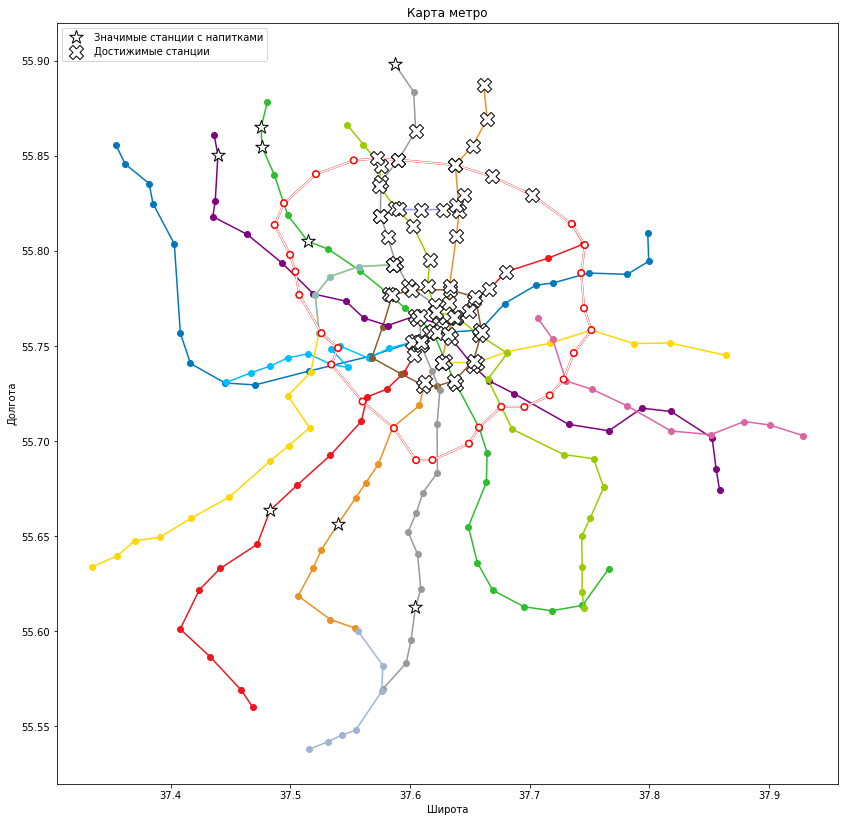

In [14]:
get_drink_preference(log=True, show_map=True)